In [1]:
import pandas as pd
import numpy as np

# Prepare Heart data

In [2]:
df = pd.read_csv("dataset/healthcare-dataset-stroke-data.csv", sep=',')
df = df.drop('id', axis=1)
df = df.dropna()
df = df.reset_index(drop=True)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4904,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
4905,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
4906,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
4907,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [4]:
numerical_fields = ['age',  'avg_glucose_level', 'bmi']
categorical = ['gender', 'hypertension', 'ever_married', 'work_type', 'heart_disease', 'Residence_type', 'smoking_status']

In [5]:
df[numerical_fields].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
age,4909.0,42.865374,22.555115,0.08,25.00,44.00,60.00,82.00
avg_glucose_level,4909.0,105.305150,44.424341,55.12,77.07,91.68,113.57,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.50,28.10,33.10,97.60


In [6]:
df[categorical + ['stroke']].astype(str).describe(include='all').T

,count,unique,top,freq
gender,4909,3,Female,2897
hypertension,4909,2,0,4458
ever_married,4909,2,Yes,3204
work_type,4909,5,Private,2811
heart_disease,4909,2,0,4666
Residence_type,4909,2,Urban,2490
smoking_status,4909,4,never smoked,1852
stroke,4909,2,0,4700


In [7]:
from sklearn.model_selection import train_test_split

y_name = 'stroke'
y = df[y_name]
y = y.astype(bool)
X = df.drop(y_name, axis=1)
X.shape

(4909, 10)

For using basick pipeline we need to binarize data. For categorical fields it is quite easy, we will use Sklearn LabelBinarizer. But for numerical fields we need to choose stratage. We have three numerical fields: Age, avg_glucose_level, bmi. For Age we will use range stratage because there are quite popular classification in biology for it. For others we will use at least stratage and set trasholds with 0.25, 0.50, 0.75 percentiles.

In [8]:
test_size = 0.1

In [9]:
X['gender'] = X['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
X['Residence_type'] = X['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
X['work_type'] = X['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)
X['ever_married'] = X['ever_married'].replace({'No':0,'Yes':1}).astype(np.uint8)
X['smoking_status'] = X['smoking_status'].replace({'never smoked':0,'Unknown':1, 'formerly smoked': 2, 'smokes': -1}).astype(np.uint8)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=test_size, shuffle=True, stratify=y)

We can see from our data, that we have much more False targets then True onec. So this will hardly affect our algorithms, so we will use SMOTE (Synthetic Minority Over-sampling Technique) to fix this.

In [10]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train.ravel())

In [11]:
X_train[categorical] = X_train[categorical].astype(str)
X_test[categorical] = X_test[categorical].astype(str)

In [12]:
X_train.shape, X_test.shape

((8460, 10), (491, 10))

# Test new proposed algorithm

In [13]:
%%time
from lazy_fca_estimator import LazyFCA
import lazy_pipeline as lpipe

fca = LazyFCA(
    consistency_threshold=0.8,
    undefined_treshhold=0.8,
    min_extent_size=10,
    check_number=1
)

prediction, t_preds_min = lpipe.apply_stopwatch(fca.predict(X_test, X_train, y_train, generator=True, verbose=1))

Predicting data....: 100%|██████████| 491/491 [00:23<00:00, 21.22it/s]

CPU times: user 23 s, sys: 193 ms, total: 23.2 s
Wall time: 23.2 s


In [14]:
from undefine_scores import f1_undefine_score, accuracy_undefine_score, recall_undefine_score
score_vals = {}
preds = prediction
score_vals['accuracy_score_new'] = [accuracy_undefine_score(y_test.iloc[:i], preds[:i]) for i in range(1, len(preds))]
score_vals['f1_score_new'] = [f1_undefine_score(y_test.iloc[:i], preds[:i], pos_label=True) for i in range(1, len(preds))]
score_vals['recall_score_new'] = [recall_undefine_score(y_test.iloc[:i], preds[:i], pos_label=True) for i in range(1, len(preds))]

/Users/alexglushko/PycharmProjects/Lazy_FCA/undefine_scores.py:59: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum((y_test == predict) & (predict == label)) / np.sum(y_test == label)
/Users/alexglushko/PycharmProjects/Lazy_FCA/undefine_scores.py:92: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum((y_test == predict) & (predict == label)) / np.sum(predict == label)
/Users/alexglushko/PycharmProjects/Lazy_FCA/undefine_scores.py:59: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum((y_test == predict) & (predict == label)) / np.sum(y_test == label)
/Users/alexglushko/PycharmProjects/Lazy_FCA/undefine_scores.py:92: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum((y_test == predict) & (predict == label)) / np.sum(predict == label)
/Users/alexglushko/PycharmProjects/Lazy_FCA/undefine_scores.py:59: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum((y_test == predict) &

# Popular estimators

In [15]:
from sklearn.preprocessing import StandardScaler

normalizer = StandardScaler()
normalizer.fit(X)
X_normalized = normalizer.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, random_state=42, test_size=test_size, shuffle=True, stratify=y)
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train.ravel())


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

lr = LogisticRegression(random_state=5, class_weight="balanced", max_iter=1000)

parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logit_cv = GridSearchCV(lr, parameters, scoring='accuracy', cv=skf, n_jobs=-1, verbose=1)
logit_cv.fit(X_normalized, y)
logit_cv_estimator = logit_cv.best_estimator_
prediction_lr = logit_cv_estimator.predict(X_test)
print("Best params:", logit_cv.best_params_)
print("Best cross validaton score %.2f"%(logit_cv.best_score_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'C': 0.0001}
Best cross validaton score 0.77


In [17]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
preds = prediction_lr
score_vals['accuracy_score_lr'] = [accuracy_score(y_test.iloc[:i], preds[:i]) for i in range(1, len(preds))]
score_vals['f1_score_lr'] = [f1_score(y_test.iloc[:i], preds[:i], zero_division=0) for i in range(1, len(preds))]
score_vals['recall_score_lr'] = [recall_score(y_test.iloc[:i], preds[:i], zero_division=0) for i in range(1, len(preds))]

In [18]:
from sklearn.svm import SVC

svc = SVC(random_state=5)

parameters = {
    "C":np.arange(1,10,1),
    'gamma':[0.00001, 0.0001,0.001,0.01,0.1,1]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svc_cv = GridSearchCV(svc, parameters, scoring='accuracy', cv=skf, n_jobs=-1, verbose=1)
svc_cv.fit(X_normalized, y)
svc_best = svc_cv.best_estimator_
prediction_svc = svc_best.predict(X_test)
print("Best params:", svc_cv.best_params_)
print("Best cross validaton score %.2f"%(svc_cv.best_score_))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params: {'C': 3, 'gamma': 0.1}
Best cross validaton score 0.96


In [19]:
preds = prediction_svc
score_vals['accuracy_score_svc'] = [accuracy_score(y_test.iloc[:i], preds[:i]) for i in range(1, len(preds))]
score_vals['f1_score_svc'] = [f1_score(y_test.iloc[:i], preds[:i], zero_division=0) for i in range(1, len(preds))]
score_vals['recall_score_svc'] = [recall_score(y_test.iloc[:i], preds[:i], zero_division=0) for i in range(1, len(preds))]

In [20]:

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

rf_cv = GridSearchCV(rf, parameters, scoring='accuracy', cv=skf, n_jobs=-1, verbose=1)
rf_cv.fit(X_normalized, y)
best_forest = rf_cv.best_estimator_
prediction_forest = best_forest.predict(X_test)
print("Best params:", rf_cv.best_params_)
print("Best cross validaton score %.2f"%(rf_cv.best_score_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'max_depth': 15, 'max_features': 4, 'min_samples_leaf': 3}
Best cross validaton score 0.95


In [21]:
preds = prediction_forest
score_vals['accuracy_score_rf'] = [accuracy_score(y_test.iloc[:i], preds[:i]) for i in range(1, len(preds))]
score_vals['f1_score_rf'] = [f1_score(y_test.iloc[:i], preds[:i], zero_division=0) for i in range(1, len(preds))]
score_vals['recall_score_rf'] = [recall_score(y_test.iloc[:i], preds[:i], zero_division=0) for i in range(1, len(preds))]

# Compare

In [22]:
n_train = int(len(X)*(1 - test_size))

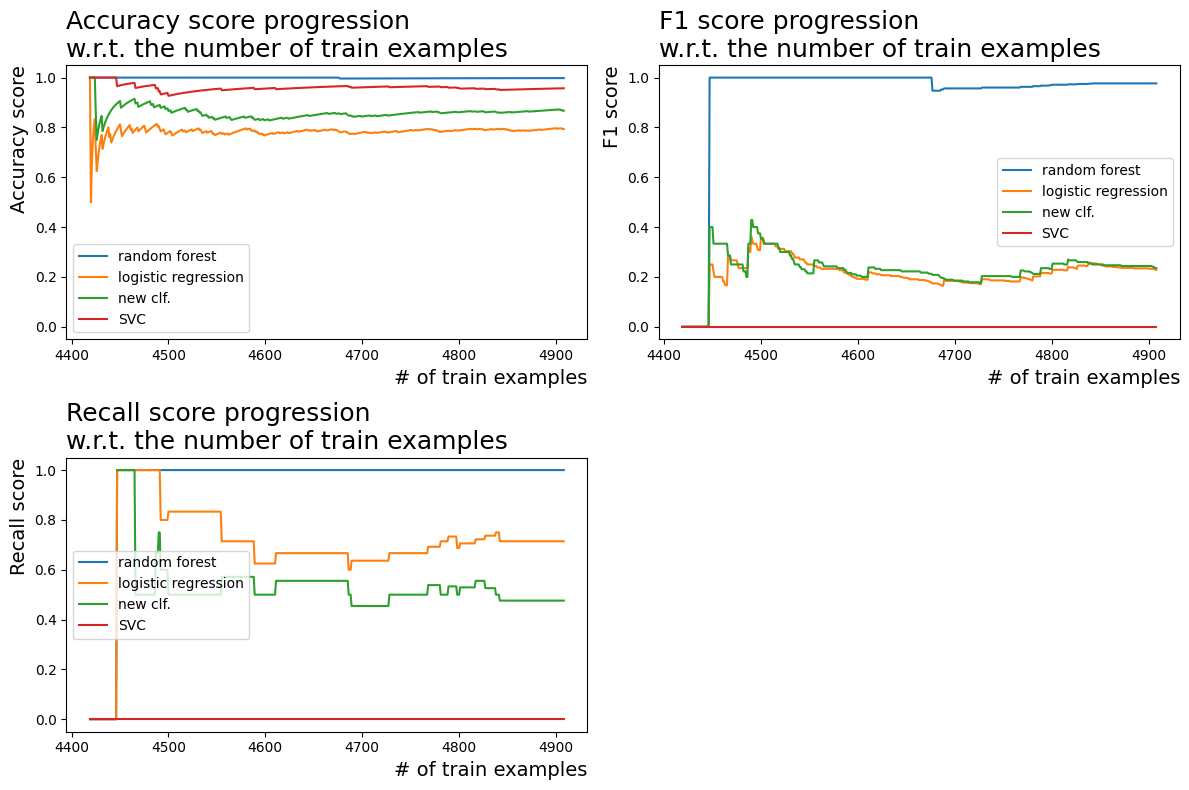

In [23]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_rf'], label='random forest')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_lr'], label='logistic regression')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_new'], label='new clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_svc'], label='SVC')
    
for ax, t in zip(axs[1],['recall_score',]):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_rf'], label='random forest')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_lr'], label='logistic regression')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_new'], label='new clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_svc'], label='SVC')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score', 'Recall score'], ['','', '']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('image/Classifier_comparison_healthcare_sklearn.png')
plt.show()